# Comparing Total Gas Masses Between Analyses - LoCuSS High-$L_{\rm{X}}$

This notebook measures gas masses for the LoCuSS High-$L_{\rm{X}}$ sample, then compares them to the measurements from literature. While the focus of this work is the measurement of total galaxy cluster masses, comparing measured gas masses gives us an avenue to probe how similar our measurements of the baryon density of the clusters are to those from literature. Seeing as knowledge of the gas density profile feeds into the total gas mass, its important to know if we are consistent.

## Import Statements

In [1]:
import pandas as pd
import numpy as np
from astropy.units import Quantity, UnitConversionError, Unit
import matplotlib.pyplot as plt
from typing import Union, List
from shutil import rmtree
import os
from tqdm import tqdm

# This adds the directory above to the path, allowing me to import the common functions that I've written in
#  common.py - this just saves me repeating boring code and makes sure its all consistent
import sys
sys.path.insert(0, '..')
from common import locuss_colour, locuss_cosmo, direct_comparison_plot, find_lims, fit_comp

import xga
# This just sets the number of cores this analysis is allowed to use
xga.NUM_CORES = 40
# This is a bodge that will only work because xga_output in notebooks has already been defined, XGA
#  will be made to handle this more gracefully at some point
temp_dir = xga.OUTPUT
actual_dir = temp_dir.split('notebooks/')[0]+'notebooks/xga_output/'
xga.OUTPUT = actual_dir
xga.utils.OUTPUT = actual_dir
# As currently XGA will setup an xga_output directory in our current directory, I remove it to keep it all clean
if os.path.exists('xga_output'):
    rmtree('xga_output')
from xga.samples import ClusterSample
from xga.imagetools.psf import rl_psf
from xga.sourcetools.density import inv_abel_fitted_model, ann_spectra_apec_norm
from xga.models import BetaProfile1D, DoubleBetaProfile1D, KingProfile1D, SimpleVikhlininDensity1D
from xga.exceptions import ModelNotAssociatedError
from xga.xspec import single_temp_apec

## Reading in Sample File and Declaring XGA ClusterSample

$\color{red}{\text{NEED TO MENTION/PUBLISH THE OBSIDS THAT WE EXCLUDE FROM USE DUE TO DATA PROBLEMS LIKE FLARING}}$

This subsection involves reading in the sample files of the four test samples (described in [the sample properties notebook](sample_properties.ipynb)), then setting up separate XGA ClusterSample instances (see [the documentation](https://xga.readthedocs.io/en/latest/notebooks/tutorials/sources_samples.html) for an introduction to XGA source and sample objects.

We impose an additional cleaning step on each sample, where we make sure that (for each XMM observation initially associated with a source) at least 70% of a cluster's $R_{500}$ falls on that observation - if this requirement is not met then the observation is excluded. These requirements are set with the `clean_obs=True`, `clean_obs_reg='r500'`, and `clean_obs_threshold=0.7` arguments when a ClusterSample instance is declared.

### LoCuSS High-$L_{\rm{X}}$

The LoCuSS High-$L_{\rm{X}}$ sample was selected from ROSAT for its high luminosity clusters, and will again be a useful comparison as testing against various different analyses is beneficial in establishing the veracity of our new measurements.

In [2]:
locuss = pd.read_csv("../../sample_files/locuss_highlx_clusters.csv", dtype={'chandra_id': str, 'xmm_obsid': str})

In [3]:
# Reading out the relevant values into arrays just for ease of passing into the ClusterSample object
ra = locuss['ra'].values
dec = locuss['dec'].values
z = locuss['z'].values
n = locuss['name'].values
r500 = Quantity(locuss['r500'].values, 'kpc')
r2500 = Quantity(locuss['r2500'].values, 'kpc')


# Declaring the actual ClusterSample instance for the LoCuSS sample
locuss_srcs = ClusterSample(ra, dec, z, n, r500=r500, r2500=r2500, cosmology=locuss_cosmo, load_fits=True, 
                            use_peak=False, clean_obs=True, clean_obs_reg='r500', clean_obs_threshold=0.7)

Declaring BaseSource Sample:  36%|███████████████▊                            | 18/50 [00:17<00:35,  1.11s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/samples/base.py:90: UserWarning: Source ZwCl0949.6+5207 does not appear to have any XMM data, and will not be included in the sample.
  warn("Source {n} does not appear to have any XMM data, and will not be included in the "
Declaring BaseSource Sample:  46%|████████████████████▏                       | 23/50 [00:21<00:28,  1.06s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/samples/base.py:90: UserWarning: Source Abell1423 does not appear to have any XMM data, and will not be included in the sample.
  warn("Source {n} does not appear to have any XMM data, and will not be included in the "
Declaring BaseSource Sample:  54%|███████████████████████▊                    | 27/50 [00:23<00:15,  1.49it/s]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/samples/base.py:90: Us

## Running PSF Correction

In [4]:
rl_psf(locuss_srcs)

Generating products of type(s) image: 100%|███████████████████████████████████| 46/46 [00:03<00:00, 14.33it/s]


## Reading in literature data

### Gas masses from literature

In [21]:
loc_lit_gms = [locuss[locuss['name'] == n].iloc[0][['x_mg500', 'x_mg500_err', 'x_mg500_err']].values
               for n in locuss_srcs.names]
loc_lit_gm2500s = [locuss[locuss['name'] == n].iloc[0][['x_mg2500', 'x_mg2500_err', 'x_mg2500_err']].values
               for n in locuss_srcs.names]
loc_lit_gms = Quantity(loc_lit_gms, 'Msun')
loc_lit_gm2500s = Quantity(loc_lit_gm2500s, 'Msun')

### Conversion Temperatures

In [6]:
loc_conv_txs = []
    
for src in locuss_srcs:
    loc_conv_txs.append(locuss[locuss['name'] == src.name].iloc[0]['x_Tx500ce'])

loc_conv_txs = Quantity(loc_conv_txs, 'keV')

## Gas Density Profile Generation and Comparison to Literature - from $S_{B}$ Profiles

### Beta and King Profiles - out to 1.3$R_{500}$

In [7]:
demo_sb_mod = BetaProfile1D()
demo_sb_mod.info()
demo_sb_mod.par_priors

╒═════════════════╤═════════════════════════════════════════════════════════════════════════════╕
│ Beta Profile    │                                                                             │
╞═════════════════╪═════════════════════════════════════════════════════════════════════════════╡
│ DESCRIBES       │ Surface Brightness                                                          │
├─────────────────┼─────────────────────────────────────────────────────────────────────────────┤
│ UNIT            │ ct / (arcmin2 s)                                                            │
├─────────────────┼─────────────────────────────────────────────────────────────────────────────┤
│ PARAMETERS      │ beta, r_core, norm                                                          │
├─────────────────┼─────────────────────────────────────────────────────────────────────────────┤
│ PARAMETER UNITS │ , kpc, ct / (arcmin2 s)                                                     │
├─────────────────┼─

[{'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.] ct / (arcmin2 s)>, 'type': 'uniform'}]

In [8]:
loc_beta_13_dp = inv_abel_fitted_model(locuss_srcs, 'beta', 'mcmc', locuss_srcs.r500*1.3, 
                                       conv_temp=loc_conv_txs)

Running XSPEC Simulations: 100%|██████████████████████████████████████████████| 46/46 [00:18<00:00,  2.55it/s]
Fitting data, inverse Abel transforming, and measuring densities: 100%|███████| 46/46 [17:42<00:00, 23.10s/it]


In [9]:
demo_d_mod = KingProfile1D(y_unit=Unit("1 / cm^3"))
demo_d_mod.info()
demo_d_mod.par_priors

╒═════════════════╤═════════════════════════════════════════════════════════════════════════╕
│ King Profile    │                                                                         │
╞═════════════════╪═════════════════════════════════════════════════════════════════════════╡
│ DESCRIBES       │ Gas Density                                                             │
├─────────────────┼─────────────────────────────────────────────────────────────────────────┤
│ UNIT            │ 1 / cm3                                                                 │
├─────────────────┼─────────────────────────────────────────────────────────────────────────┤
│ PARAMETERS      │ beta, r_core, norm                                                      │
├─────────────────┼─────────────────────────────────────────────────────────────────────────┤
│ PARAMETER UNITS │ , kpc, 1 / cm3                                                          │
├─────────────────┼─────────────────────────────────────────

[{'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [ 0., 10.] 1 / cm3>, 'type': 'uniform'}]

In [10]:
with tqdm(desc="Fitting density model to LoCuSS profiles", total=len(loc_beta_13_dp)) as onwards:
    for dp in loc_beta_13_dp:
        if dp is not None:
            dp.fit('king', progress_bar=False)
        onwards.update(1)

Fitting density model to LoCuSS profiles: 100%|███████████████████████████████| 46/46 [25:40<00:00, 33.49s/it]


In [11]:
loc_beta_king_13_gm500 = []
loc_beta_king_13_gm2500 = []

with tqdm(desc="Calculating LoCuSS gas masses", total=len(loc_beta_13_dp)) as onwards:
    for dp in loc_beta_13_dp:
        if dp is not None:
            gm = dp.gas_mass("king", locuss_srcs[dp.src_name].r500)[0]
            loc_beta_king_13_gm500.append(gm)
            gm = dp.gas_mass("king", locuss_srcs[dp.src_name].r2500)[0]
            loc_beta_king_13_gm2500.append(gm)
        else:
            loc_beta_king_13_gm2500.append([np.NaN, np.NaN, np.NaN])
            loc_beta_king_13_gm500.append([np.NaN, np.NaN, np.NaN])
        onwards.update(1)               
        
loc_beta_king_13_gm500 = Quantity(loc_beta_king_13_gm500, 'Msun')
loc_beta_king_13_gm2500 = Quantity(loc_beta_king_13_gm2500, 'Msun')

Calculating LoCuSS gas masses: 100%|██████████████████████████████████████████| 46/46 [01:40<00:00,  2.18s/it]


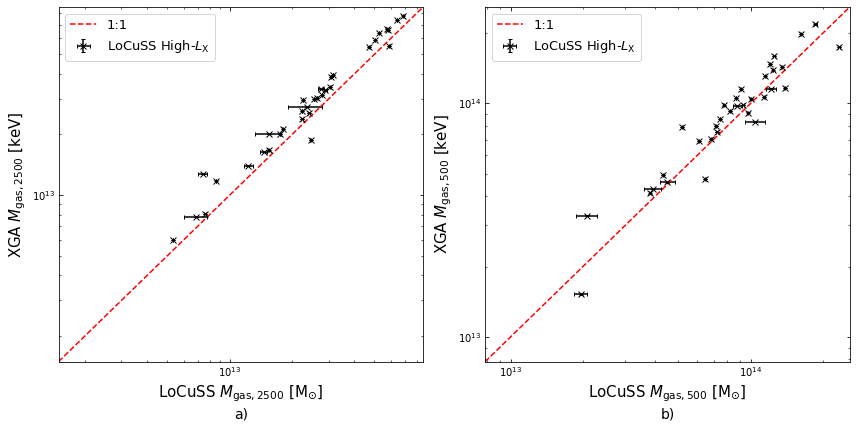

In [24]:
direct_comparison_plot([loc_lit_gm2500s, loc_lit_gms], [loc_beta_king_13_gm2500, loc_beta_king_13_gm500], 
                       [r"LoCuSS $M_{\rm{gas, 2500}}$ [M$_{\odot}$]", r"LoCuSS $M_{\rm{gas, 500}}$ [M$_{\odot}$]"], 
                       [r"XGA $M_{\rm{gas, 2500}}$ [keV]", r"XGA $M_{\rm{gas, 500}}$ [keV]"],
                       r"LoCuSS High-$L_{\rm{X}}$", (12, 6), ['log', 'log'], ['log', 'log'])
# savepath='../../outputs/figures/locussBLAH_comp.pdf'

### Double Beta and Simplified Vikhlinin Profiles - out to 1.3$R_{500}$

In [25]:
demo_sb_mod = DoubleBetaProfile1D()
demo_sb_mod.info()
demo_sb_mod.par_priors

╒═══════════════════════╤════════════════════════════════════════════════════════════════════════════╕
│ Double Beta Profile   │                                                                            │
╞═══════════════════════╪════════════════════════════════════════════════════════════════════════════╡
│ DESCRIBES             │ Surface Brightness                                                         │
├───────────────────────┼────────────────────────────────────────────────────────────────────────────┤
│ UNIT                  │ ct / (arcmin2 s)                                                           │
├───────────────────────┼────────────────────────────────────────────────────────────────────────────┤
│ PARAMETERS            │ beta_one, r_core_one, norm_one, beta_two, r_core_two, norm_two             │
├───────────────────────┼────────────────────────────────────────────────────────────────────────────┤
│ PARAMETER UNITS       │ , kpc, ct / (arcmin2 s), , kpc, ct / (arcmin2 s

[{'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [1.e+00, 2.e+03] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.] ct / (arcmin2 s)>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [1.e+00, 2.e+03] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.] ct / (arcmin2 s)>, 'type': 'uniform'}]

In [26]:
loc_dblbeta_13_dp = inv_abel_fitted_model(locuss_srcs, 'double_beta', 'mcmc', locuss_srcs.r500*1.3, 
                                       conv_temp=loc_conv_txs)

/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/xspec/run.py:186: UserWarning: All XSPEC operations had already been run.
  warnings.warn("All XSPEC operations had already been run.")
Fitting data, inverse Abel transforming, and measuring densities:   0%|                | 0/46 [00:00<?, ?it/s]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1235.96494558  596.77776403 1244.27798609 1174.3351953  1291.96376133
 1264.89001821]


Fitting data, inverse Abel transforming, and measuring densities:   2%|▏       | 1/46 [00:25<19:18, 25.75s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [451.65611343 391.22574807 453.99038263 388.40590373 402.77502803
 461.09889828]


Fitting data, inverse Abel transforming, and measuring densities:   7%|▌       | 3/46 [01:18<18:40, 26.05s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1208.97757159  654.78468809 1083.82328497 1049.816384   1146.6762845
 1136.16701934]


Fitting data, inverse Abel transforming, and measuring densities:   9%|▋       | 4/46 [01:42<17:28, 24.98s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 709.99089641 1320.59368293 1270.68310522 1508.24029215 1562.71111595
 1536.42261504]


Fitting data, inverse Abel transforming, and measuring densities:  11%|▊       | 5/46 [02:06<17:00, 24.90s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [555.51711932 731.77189642 228.06187926 221.43967102 415.49327393
 352.24863626]


Fitting data, inverse Abel transforming, and measuring densities:  13%|█       | 6/46 [02:32<16:39, 24.99s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [166.01921216 440.98607497 514.98811616 400.54658462 453.24873355
 534.67901666]


Fitting data, inverse Abel transforming, and measuring densities:  15%|█▏      | 7/46 [02:59<16:45, 25.78s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 492.32011519  238.33471648 1880.14547614 1797.13899953 1863.45166812
 1756.76144431]


Fitting data, inverse Abel transforming, and measuring densities:  22%|█▌     | 10/46 [04:22<16:21, 27.25s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [178.17597554 382.13212018 529.49419022 242.11724912 185.64725776
 186.97988854]


Fitting data, inverse Abel transforming, and measuring densities:  28%|█▉     | 13/46 [05:39<14:24, 26.18s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1848.09294504 1780.39690822 2032.8607217  2166.42826556 2218.31399417
 2156.37477758]
The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 351.33473691  827.87454424  916.04764983  697.85689645  811.42778133
 1040.77745021]


Fitting data, inverse Abel transforming, and measuring densities:  33%|██▎    | 15/46 [06:31<13:35, 26.32s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [427.20841566 413.78219139 250.88198889 319.30507073 349.6221864
 423.91993711]


Fitting data, inverse Abel transforming, and measuring densities:  35%|██▍    | 16/46 [06:56<12:57, 25.93s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 687.24109363  333.53421457 1843.95778275 1373.24188467 1414.57931619
 1552.30865494]


Fitting data, inverse Abel transforming, and measuring densities:  37%|██▌    | 17/46 [07:23<12:40, 26.21s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of Abell0781's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  39%|██▋    | 18/46 [07:45<11:40, 25.02s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1918.51808236  375.92557343 1983.48968482  595.82908551  585.79395139
 1980.38747906]


Fitting data, inverse Abel transforming, and measuring densities:  48%|███▎   | 22/46 [09:41<11:11, 27.98s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1830.53070609  321.15203077 2334.77452842 1988.86450446  834.7646783
 2307.389643  ]


Fitting data, inverse Abel transforming, and measuring densities:  50%|███▌   | 23/46 [10:06<10:25, 27.20s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of RXCJ1212.3-1816's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  52%|███▋   | 24/46 [10:26<09:12, 25.10s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1447.05895778  621.5187545  1555.37770658 1026.51091613  720.51385583
 1555.42715788]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 626.66658578 1399.38869985 1375.35380756  807.82478373 1442.2273757
 1387.92441209]


Fitting data, inverse Abel transforming, and measuring densities:  57%|███▉   | 26/46 [11:24<09:08, 27.44s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of Abell1758N's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  59%|████   | 27/46 [11:46<08:11, 25.89s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1828.03405176  367.3796361  1944.55688747  909.00442947  715.82031129
 1942.5880007 ]
The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [317.02340848 348.14636767 749.39547697 661.19459271 504.78538607
 412.81581079]


Fitting data, inverse Abel transforming, and measuring densities:  72%|█████  | 33/46 [14:34<05:53, 27.19s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 882.61635671  643.86147119 1866.05894329 1284.45745615 1445.94946578
 1847.50422075]


Fitting data, inverse Abel transforming, and measuring densities:  74%|█████▏ | 34/46 [14:59<05:20, 26.73s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1123.5398005   730.69148274 1044.85372017  871.47976602  950.16906618
 1030.37018163]


Fitting data, inverse Abel transforming, and measuring densities:  78%|█████▍ | 36/46 [15:56<04:37, 27.77s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [208.51131968 369.48367665 430.62212874 495.83653973 516.6620335
 468.78560529]


Fitting data, inverse Abel transforming, and measuring densities:  93%|██████▌| 43/46 [19:16<01:23, 27.83s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [621.37117132 449.84193591 670.28681068 513.07761141 569.67878172
 789.3784336 ]


Fitting data, inverse Abel transforming, and measuring densities:  96%|██████▋| 44/46 [19:43<00:55, 27.71s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [578.16169514 500.3604728  525.59753493 358.81020154 426.19178466
 533.81989571]


Fitting data, inverse Abel transforming, and measuring densities:  98%|██████▊| 45/46 [20:07<00:26, 26.64s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1296.08502634  947.10978321 1710.50096705 1110.37015967 1258.73999584
 1665.29698944]


Fitting data, inverse Abel transforming, and measuring densities: 100%|███████| 46/46 [20:32<00:00, 26.79s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 491.67067333  300.29322235 1762.35212714 1727.20710578 1530.94615324
 1792.72524268]


In [27]:
demo_d_mod = SimpleVikhlininDensity1D(y_unit=Unit("1 / cm^3"))
demo_d_mod.info()
demo_d_mod.par_priors

╒════════════════════════════════╤═══════════════════════════════════════════════════════════════════════╕
│ Simplified Vikhlinin Profile   │                                                                       │
╞════════════════════════════════╪═══════════════════════════════════════════════════════════════════════╡
│ DESCRIBES                      │ Gas Density                                                           │
├────────────────────────────────┼───────────────────────────────────────────────────────────────────────┤
│ UNIT                           │ 1 / cm3                                                               │
├────────────────────────────────┼───────────────────────────────────────────────────────────────────────┤
│ PARAMETERS                     │ beta, r_core, alpha, r_s, epsilon, norm                               │
├────────────────────────────────┼───────────────────────────────────────────────────────────────────────┤
│ PARAMETER UNITS                │ , 

[{'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 5.]>, 'type': 'uniform'},
 {'prior': <Quantity [ 0., 10.] 1 / cm3>, 'type': 'uniform'}]

In [28]:
with tqdm(desc="Fitting density model to LoCuSS profiles", total=len(loc_dblbeta_13_dp)) as onwards:
    for dp in loc_dblbeta_13_dp:
        if dp is not None:
            dp.fit('simple_vikhlinin_dens', progress_bar=False)
        onwards.update(1)

Fitting density model to LoCuSS profiles:  13%|████▏                           | 6/46 [04:17<27:49, 41.74s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 94.73485021  93.39308252 960.8336585  102.92028049 132.87009622
  96.18475526]


Fitting density model to LoCuSS profiles:  15%|████▊                           | 7/46 [05:04<28:23, 43.69s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [610.85495269 875.65721752 982.46414917 466.96771744 610.17264115
 980.94727293]


Fitting density model to LoCuSS profiles:  17%|█████▌                          | 8/46 [05:48<27:34, 43.54s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 95.19824046  96.37199448 967.27440964  98.8573933  129.44133588
  96.26290552]


Fitting density model to LoCuSS profiles:  22%|██████▋                        | 10/46 [07:16<26:25, 44.04s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 82.1095695   85.06656546 713.08690186  84.68135498  82.13924085
  85.04068453]


Fitting density model to LoCuSS profiles:  24%|███████▍                       | 11/46 [07:59<25:27, 43.65s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1980.59114195 2275.70091286 1960.36351588 2300.31998359 1784.57387411
 2075.68014736]


Fitting density model to LoCuSS profiles:  28%|████████▊                      | 13/46 [09:25<23:52, 43.41s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 559.07473263  893.77332075  997.36564363  407.99537525  206.1940593
 1032.12401442]


Fitting density model to LoCuSS profiles:  35%|██████████▊                    | 16/46 [11:34<21:15, 42.53s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1756.03702342 2011.44121169 2117.5400082  2377.26745129  607.19482671
 2252.89961072]


Fitting density model to LoCuSS profiles:  41%|████████████▊                  | 19/46 [13:03<15:07, 33.60s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 89.66504573  90.6541549  649.14991914  87.72162652  81.21526067
  95.6954886 ]


Fitting density model to LoCuSS profiles:  46%|██████████████▏                | 21/46 [14:35<16:13, 38.96s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [  97.38841356  100.83650426 1072.77727344   95.38785108   99.0974074
  101.66151044]


Fitting density model to LoCuSS profiles:  61%|██████████████████▊            | 28/46 [18:27<09:24, 31.35s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 108.5687461   106.73878121 1220.96056438  113.3863297   114.2812409
  102.91778644]


Fitting density model to LoCuSS profiles:  67%|████████████████████▉          | 31/46 [20:47<09:53, 39.58s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 94.82715283  91.86467608 755.56189491 111.76377967 119.34025115
  89.69607147]


Fitting density model to LoCuSS profiles:  72%|██████████████████████▏        | 33/46 [22:20<09:09, 42.29s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 537.75024897  513.77733407 2255.96832104  519.22805064  255.07025986
 1053.88768655]


Fitting density model to LoCuSS profiles:  74%|██████████████████████▉        | 34/46 [23:10<08:54, 44.51s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 72.67778916  75.66415851 750.0940742   80.57180914  80.5565993
  46.26028116]


Fitting density model to LoCuSS profiles:  93%|████████████████████████████▉  | 43/46 [30:26<02:18, 46.14s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 836.96385164 1110.34187841 1033.52539064  572.65664972  259.00092343
 1195.19260055]


Fitting density model to LoCuSS profiles:  98%|██████████████████████████████▎| 45/46 [31:56<00:45, 45.47s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [215.94133805 218.84944572 627.96054079 214.11759221 130.58700258
 279.58598876]


Fitting density model to LoCuSS profiles: 100%|███████████████████████████████| 46/46 [32:41<00:00, 42.63s/it]


In [30]:
loc_dblbeta_svikh_13_gm500 = []
loc_dblbeta_svikh_13_gm2500 = []
with tqdm(desc="Calculating LoCuSS gas masses", total=len(loc_dblbeta_13_dp)) as onwards:
    for dp in loc_dblbeta_13_dp:
        if dp is not None:
            gm = dp.gas_mass("simple_vikhlinin_dens", locuss_srcs[dp.src_name].r500)[0]
            loc_dblbeta_svikh_13_gm500.append(gm)
            gm = dp.gas_mass("simple_vikhlinin_dens", locuss_srcs[dp.src_name].r2500)[0]
            loc_dblbeta_svikh_13_gm2500.append(gm)
        else:
            loc_dblbeta_svikh_13_gm500.append([np.NaN, np.NaN, np.NaN])
            loc_dblbeta_svikh_13_gm2500.append([np.NaN, np.NaN, np.NaN])
            
        onwards.update(1)        

loc_dblbeta_svikh_13_gm500 = Quantity(loc_dblbeta_svikh_13_gm500, 'Msun')
loc_dblbeta_svikh_13_gm2500 = Quantity(loc_dblbeta_svikh_13_gm2500, 'Msun')

Calculating LoCuSS gas masses: 100%|██████████████████████████████████████████| 46/46 [00:07<00:00,  5.76it/s]


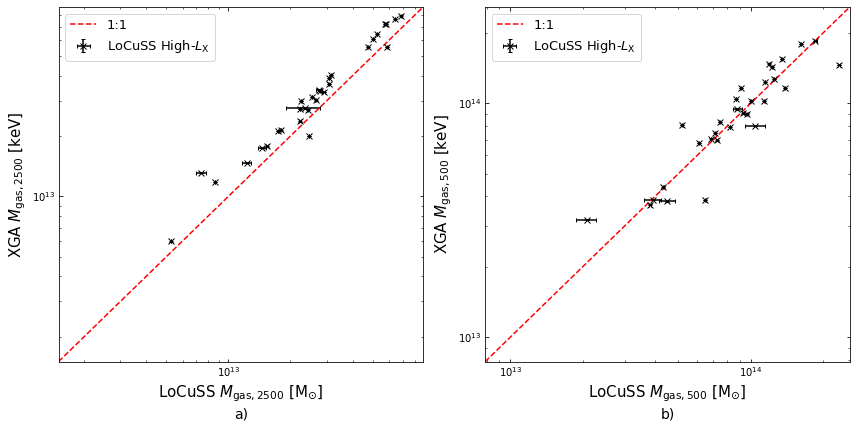

In [42]:
direct_comparison_plot([loc_lit_gm2500s, loc_lit_gms], [loc_dblbeta_svikh_13_gm2500, loc_dblbeta_svikh_13_gm500], 
                       [r"LoCuSS $M_{\rm{gas, 2500}}$ [M$_{\odot}$]", r"LoCuSS $M_{\rm{gas, 500}}$ [M$_{\odot}$]"], 
                       [r"XGA $M_{\rm{gas, 2500}}$ [keV]", r"XGA $M_{\rm{gas, 500}}$ [keV]"],
                       r"LoCuSS High-$L_{\rm{X}}$", (12, 6), ['log', 'log'], ['log', 'log'], 
                       savepath='../../outputs/figures/locuss_13r500_gmcomp_dblbeta_svikh.pdf')

In [33]:
loc_dblbeta_svikh_13_gm500.shape

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


(46, 3)

### Double Beta and Simplified Vikhlinin Profiles - out to 1.1$R_{500}$

In [37]:
loc_dblbeta_11_dp = inv_abel_fitted_model(locuss_srcs, 'double_beta', 'mcmc', locuss_srcs.r500*1.1, 
                                       conv_temp=loc_conv_txs)

/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/xspec/run.py:186: UserWarning: All XSPEC operations had already been run.
  warnings.warn("All XSPEC operations had already been run.")
Fitting data, inverse Abel transforming, and measuring densities:   2%|▏       | 1/46 [00:25<19:01, 25.36s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 985.27256554  954.73949601 1383.39116334 1235.09631068 1305.92188192
 1344.74042213]
The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [391.72401274 253.33825148 470.85914709 435.86921732 435.33873632
 461.06689984]


Fitting data, inverse Abel transforming, and measuring densities:   7%|▌       | 3/46 [01:18<18:36, 25.97s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1247.76025194  410.35092375 1188.36251349 1043.47694835 1152.51420881
 1199.21524028]


Fitting data, inverse Abel transforming, and measuring densities:   9%|▋       | 4/46 [01:41<17:23, 24.85s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 929.9853572  2038.04788287 1366.1544906  1909.0730638  1993.26395336
 2005.37441592]


Fitting data, inverse Abel transforming, and measuring densities:  11%|▊       | 5/46 [02:05<16:49, 24.63s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [415.97742018 591.59161156 135.84613755 222.25532993 420.84568827
 419.19844489]


Fitting data, inverse Abel transforming, and measuring densities:  17%|█▍      | 8/46 [03:21<15:48, 24.95s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 442.90983031  435.09701483 1801.06387091 1744.98358227 1825.67460396
 1754.37005954]


Fitting data, inverse Abel transforming, and measuring densities:  20%|█▌      | 9/46 [03:48<15:55, 25.82s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [424.34913993 404.76311371 329.01722725 271.39724955 307.95810668
 367.52580919]


Fitting data, inverse Abel transforming, and measuring densities:  28%|█▉     | 13/46 [05:31<14:00, 25.46s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 986.94697346  866.50150595 1151.38739684 1213.23575162 1308.41446873
 1360.98063994]


Fitting data, inverse Abel transforming, and measuring densities:  30%|██▏    | 14/46 [05:56<13:26, 25.19s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 270.39642011  816.81451726  919.9846905   690.17510153  809.595381
 1068.19583518]


Fitting data, inverse Abel transforming, and measuring densities:  33%|██▎    | 15/46 [06:22<13:10, 25.49s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1042.60904094 1055.74165997  893.38604883  747.19988274  844.38269202
 1001.80006225]


Fitting data, inverse Abel transforming, and measuring densities:  37%|██▌    | 17/46 [07:12<12:14, 25.32s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 654.76298046  446.0565091  1672.23259074 1248.32074362 1261.19971695
 1418.35254313]


Fitting data, inverse Abel transforming, and measuring densities:  39%|██▋    | 18/46 [07:35<11:29, 24.63s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 232.84416107 1000.43410806 2009.90392829 2401.78806296 2356.45065104
 1924.95096459]


Fitting data, inverse Abel transforming, and measuring densities:  43%|███    | 20/46 [08:31<11:29, 26.53s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [484.37578718 471.82074142 394.78074361 367.7876267  388.81660937
 454.59673165]


Fitting data, inverse Abel transforming, and measuring densities:  48%|███▎   | 22/46 [09:28<11:00, 27.51s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 795.24037819  224.10539744 1719.716318   1440.52568137 1117.65241574
 1645.61256714]


Fitting data, inverse Abel transforming, and measuring densities:  50%|███▌   | 23/46 [09:54<10:17, 26.86s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of RXCJ1212.3-1816's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  52%|███▋   | 24/46 [10:14<09:11, 25.07s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 958.50474424 1114.08423012 1945.67521176 1252.76718362 1806.63423062
 1947.65909623]


Fitting data, inverse Abel transforming, and measuring densities:  54%|███▊   | 25/46 [10:38<08:35, 24.54s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1315.2187529   928.96657997 2326.39862163 1326.58461443 1592.23029785
 2301.26680295]


Fitting data, inverse Abel transforming, and measuring densities:  59%|████   | 27/46 [11:30<07:55, 25.00s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1848.49343033  241.31073648 2215.40420705  998.77845016  819.96871658
 2210.57588785]


Fitting data, inverse Abel transforming, and measuring densities:  61%|████▎  | 28/46 [11:56<07:33, 25.18s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 812.4138443   896.01730417 1771.51507122 1548.94984264 1094.60403784
 1205.31603956]


Fitting data, inverse Abel transforming, and measuring densities:  72%|█████  | 33/46 [14:08<05:36, 25.87s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1022.84287322  864.31014843 1938.17264421 1486.34086965 1656.97737165
 1936.16352238]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [434.3805257  296.48523676 100.55234421 357.57786884 126.6905303
  91.13856881]


Fitting data, inverse Abel transforming, and measuring densities:  76%|█████▎ | 35/46 [15:00<04:43, 25.81s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 955.22357811  600.54740619 1156.73416273  969.34318681 1049.05979434
 1189.27204371]


Fitting data, inverse Abel transforming, and measuring densities:  78%|█████▍ | 36/46 [15:28<04:26, 26.67s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [424.3759295  375.29728384 497.59527384 280.14106794 323.44196724
 450.46970523]


Fitting data, inverse Abel transforming, and measuring densities:  85%|█████▉ | 39/46 [16:51<03:11, 27.31s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [980.72824899 983.1175923  985.49510968 828.31551994 946.95338997
 981.15946161]


Fitting data, inverse Abel transforming, and measuring densities:  93%|██████▌| 43/46 [18:38<01:19, 26.47s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1149.67826888  847.0150992  1127.24243401  974.47455399 1094.0347057
 1231.99773898]


Fitting data, inverse Abel transforming, and measuring densities:  96%|██████▋| 44/46 [19:04<00:52, 26.36s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [362.95375189 336.79190994 447.52585892 284.56108367 369.12835536
 504.04274481]


Fitting data, inverse Abel transforming, and measuring densities:  98%|██████▊| 45/46 [19:28<00:25, 25.62s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 972.83058829  922.42882658 1835.80649803 1291.46147959 1177.09116273
 1830.58262774]


Fitting data, inverse Abel transforming, and measuring densities: 100%|███████| 46/46 [19:52<00:00, 25.92s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [522.76864078 648.25618934 831.23191155 559.3648401  639.90744814
 888.35996186]


In [39]:
with tqdm(desc="Fitting density model to LoCuSS profiles", total=len(loc_dblbeta_11_dp)) as onwards:
    for dp in loc_dblbeta_11_dp:
        if dp is not None:
            dp.fit('simple_vikhlinin_dens', progress_bar=False)
        onwards.update(1)

Fitting density model to LoCuSS profiles:   2%|▋                               | 1/46 [00:42<31:45, 42.35s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [107.62066    138.74559134 681.09318867 104.04312709 105.70349231
 261.54790743]


Fitting density model to LoCuSS profiles:   7%|██                              | 3/46 [02:09<30:41, 42.82s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [122.12422136 176.13712026 661.30594337 132.45771845 137.89856166
 368.12814617]


Fitting density model to LoCuSS profiles:  13%|████▏                           | 6/46 [04:09<27:01, 40.54s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 97.38062897  93.22524032 890.65494095 113.27221983 121.25537591
  96.29316057]


Fitting density model to LoCuSS profiles:  15%|████▊                           | 7/46 [04:55<27:34, 42.42s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 769.38230481 1312.66795221 1142.74912005  475.26185518  798.43555634
 1339.05974052]


Fitting density model to LoCuSS profiles:  22%|██████▋                        | 10/46 [07:04<25:44, 42.91s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 86.80826088  86.2430542  701.98741985  83.95760226  87.7583177
  86.73251627]


Fitting density model to LoCuSS profiles:  24%|███████▍                       | 11/46 [07:45<24:41, 42.32s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2090.97705976 2361.93392368 1816.53257523 2247.46946442 2072.02815732
 1956.04183496]


Fitting density model to LoCuSS profiles:  28%|████████▊                      | 13/46 [09:09<23:07, 42.03s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [316.36366386 396.62520766 786.87059375 229.57797881 180.75408994
 460.85829639]


Fitting density model to LoCuSS profiles:  33%|██████████                     | 15/46 [10:34<21:43, 42.04s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [100.74409326 103.43599181 836.52887934 107.86537151 117.76949753
 113.35484106]


Fitting density model to LoCuSS profiles:  35%|██████████▊                    | 16/46 [11:12<20:31, 41.05s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1870.18083269 1771.90130431 1163.80927041 1891.98711715 1037.00489769
 1332.6934066 ]


Fitting density model to LoCuSS profiles:  39%|████████████▏                  | 18/46 [12:37<19:28, 41.73s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1832.5623114  1856.17801663  380.7067552   973.7001594  1841.35666271
  473.69693025]


Fitting density model to LoCuSS profiles:  41%|████████████▊                  | 19/46 [13:21<19:04, 42.41s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 81.7700017   90.04458925 676.05663188  78.23974438  82.14912993
  87.58977925]


Fitting density model to LoCuSS profiles:  59%|██████████████████▏            | 27/46 [18:30<12:07, 38.28s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1747.70691824 1744.47779622  532.61667185 1022.5170002  1492.79684447
  614.57740305]


Fitting density model to LoCuSS profiles:  67%|████████████████████▉          | 31/46 [21:28<10:33, 42.24s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [  93.34490101   95.57267558 1115.84694883   96.25509229  116.91237971
   95.53418303]


Fitting density model to LoCuSS profiles:  72%|██████████████████████▏        | 33/46 [22:55<09:12, 42.48s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1591.9618434  1704.90278602 1001.79226141 1931.64720838 1176.60802694
 1582.24665211]


Fitting density model to LoCuSS profiles:  93%|████████████████████████████▉  | 43/46 [30:40<02:15, 45.10s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1079.29708391 1333.94262561 1496.45290294  676.32956805  283.35429871
 1414.28179439]


Fitting density model to LoCuSS profiles: 100%|███████████████████████████████| 46/46 [32:52<00:00, 42.87s/it]


In [40]:
loc_dblbeta_svikh_11_gm500 = []
loc_dblbeta_svikh_11_gm2500 = []
with tqdm(desc="Calculating LoCuSS gas masses", total=len(loc_dblbeta_11_dp)) as onwards:
    for dp in loc_dblbeta_11_dp:
        if dp is not None:
            gm = dp.gas_mass("simple_vikhlinin_dens", locuss_srcs[dp.src_name].r500)[0]
            loc_dblbeta_svikh_11_gm500.append(gm)
            gm = dp.gas_mass("simple_vikhlinin_dens", locuss_srcs[dp.src_name].r2500)[0]
            loc_dblbeta_svikh_11_gm2500.append(gm)
        else:
            loc_dblbeta_svikh_11_gm500.append([np.NaN, np.NaN, np.NaN])
            loc_dblbeta_svikh_11_gm2500.append([np.NaN, np.NaN, np.NaN])
            
        onwards.update(1)        

loc_dblbeta_svikh_11_gm500 = Quantity(loc_dblbeta_svikh_11_gm500, 'Msun')
loc_dblbeta_svikh_11_gm2500 = Quantity(loc_dblbeta_svikh_11_gm2500, 'Msun')

Calculating LoCuSS gas masses: 100%|██████████████████████████████████████████| 46/46 [07:35<00:00,  9.91s/it]


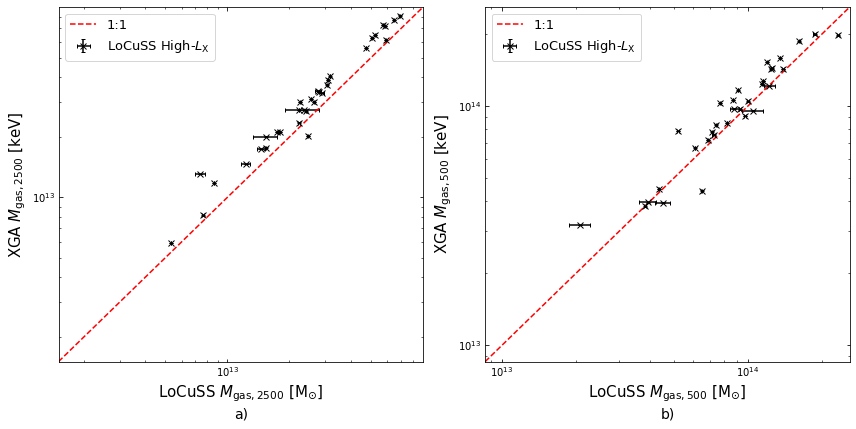

In [41]:
direct_comparison_plot([loc_lit_gm2500s, loc_lit_gms], [loc_dblbeta_svikh_11_gm2500, loc_dblbeta_svikh_11_gm500], 
                       [r"LoCuSS $M_{\rm{gas, 2500}}$ [M$_{\odot}$]", r"LoCuSS $M_{\rm{gas, 500}}$ [M$_{\odot}$]"], 
                       [r"XGA $M_{\rm{gas, 2500}}$ [keV]", r"XGA $M_{\rm{gas, 500}}$ [keV]"],
                       r"LoCuSS High-$L_{\rm{X}}$", (12, 6), ['log', 'log'], ['log', 'log'])
# savepath='../../outputs/figures/locussBLAH_comp.pdf'